============================== Caso 5 — Regresión Logística ==============================

Accuracy: 0.454545
Precision (clase 1): 0.666667
Recall    (clase 1): 0.500000
F1-score            : 0.571429
ROC-AUC             : 0.583333

Probabilidad de día alcista (último día del dataset): 0.628731


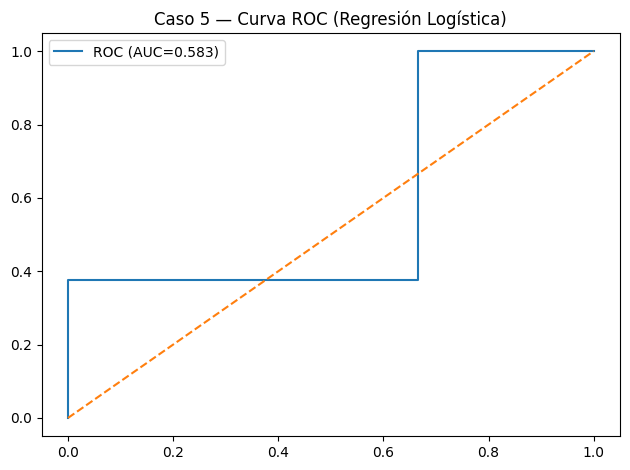

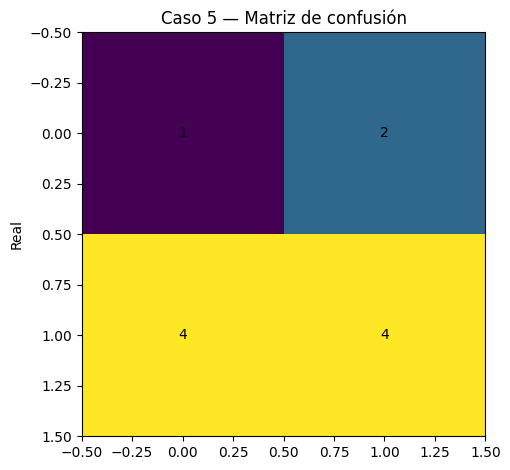


Concusión:
La discriminación es baja; difícilmente aporta una ventaja por sí solo.
Variable más influyente (magnitud |β|): lag2 (|β|=0.405188)

Si se compra sólo si P>=0.60, el porcentaje de días con señal de compra sería: 0.181818


In [3]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

ruta = "case2_utilities_defensive.csv"
dataframe = pd.read_csv(ruta)

if 'return' not in dataframe.columns:
    raise ValueError("El CSV debe contener la columna 'return'.")
if dataframe['return'].isna().any():
    dataframe = dataframe.dropna(subset=['return'])

r = dataframe['return'].astype(float)
if r.abs().max() > 1:
    r = r / 100.0

df = pd.DataFrame({'return': r}).copy()
df['target'] = (df['return'] > 0).astype(int)

for k in range(1, 4):
    df[f'lag{k}'] = df['return'].shift(k)
shift = df['return'].shift(1)
df['roll_mean_5'] = shift.rolling(window=5, min_periods=5).mean()
df['roll_std_5'] = shift.rolling(window=5, min_periods=5).std(ddof=1)
df = df.dropna().reset_index(drop=True)

columnas_x = ['lag1', 'lag2', 'lag3', 'roll_mean_5', 'roll_std_5']
x = df[columnas_x].values
y = df['target'].values

n = len(df)
n_train = int(np.floor(0.8 * n))
X_train, X_test = x[:n_train], x[n_train:]
y_train, y_test = y[:n_train], y[n_train:]

escalador = StandardScaler()
X_train_scaled = escalador.fit_transform(X_train)
X_test_scaled = escalador.transform(X_test)

modelo = LogisticRegression(solver='lbfgs', max_iter=1000)
modelo.fit(X_train_scaled, y_train)

y_proba = modelo.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_proba)

X_ultimo = x[-1:].copy()
X_ultimo_scaled = escalador.transform(X_ultimo)
prob_ultimo = modelo.predict_proba(X_ultimo_scaled)[0, 1]

print(f"{'='*30} Caso 5 — Regresión Logística {'='*30}\n")
print(f"Accuracy: {accuracy:.6f}")
print(f"Precision (clase 1): {precision:.6f}")
print(f"Recall    (clase 1): {recall:.6f}")
print(f"F1-score            : {f1:.6f}")
print(f"ROC-AUC             : {roc_auc:.6f}")
print(f"\nProbabilidad de día alcista (último día del dataset): {prob_ultimo:.6f}")

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC (AUC={roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('Caso 5 — Curva ROC (Regresión Logística)')
plt.legend()
plt.tight_layout()
plt.show()

cm = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Caso 5 — Matriz de confusión')
plt.ylabel('Real')
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha='center', va='center')
plt.tight_layout()
plt.show()

print("\nConcusión:")
if roc_auc >= 0.7:
    print("El modelo separa razonablemente bien días alcistas y bajistas; útil para señales.")
elif roc_auc >= 0.6:
    print("La discriminación es modesta; podría servir como componente de un ensemble.")
else:
    print("La discriminación es baja; difícilmente aporta una ventaja por sí solo.")

coef = np.abs(modelo.coef_[0])
idx_max = int(np.argmax(coef))
print(f"Variable más influyente (magnitud |β|): {columnas_x[idx_max]} (|β|={coef[idx_max]:.6f})")

umbral = 0.60
precision_umbral = (y_proba >= umbral).mean()
print(f"\nSi se compra sólo si P>={umbral:.2f}, el porcentaje de días con señal de compra sería: {precision_umbral:.6f}")